In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# get data
from folktables import ACSDataSource, ACSIncome
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp
import seaborn as sns

<IPython.core.display.Javascript object>

## Section 0: Data generation and helper functions

In [5]:
# bin keys
occp_bins = [
    0,
    1000,
    1300,
    1600,
    2000,
    2100,
    2200,
    2600,
    3000,
    3600,
    4700,
    6000,
    7700,
    10000,
]
occp_labels = [
    "MGR",
    "CMM",
    "ENG",
    "SCI",
    "CMS",
    "LGL",
    "EDU",
    "ENT",
    "MED",
    "SVO",
    "OFF",
    "NRS",
    "PTM",
]
income_bins = [0, 20000, 40000, 60000, 80000, 100000, np.inf]
income_labels = ["0-20k", "20-40k", "40-60k", "60-80k", "80-100k", "100k+"]

<IPython.core.display.Javascript object>

In [6]:
# generate data
# plot utility instead
# custom variables
year = "2021"
states = ["CA"]
job_industry = "ENT"
ctr_base = 1  # this is the default click through rate

data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")

state_data = data_source.get_data(states=states, download=True)

# filter cells
state_data = state_data[["AGEP", "SEX", "RAC1P", "OCCP", "PINCP"]].dropna()
# filter race to White, Black or AA, Asian
state_data = state_data[state_data["RAC1P"].isin([1, 2, 6])]
print(f"remaining number of individuals {len(state_data)}")

# cut cells
# occupation
state_data["COCCP"] = pd.cut(
    x=state_data["OCCP"].dropna(),
    bins=occp_bins,
    labels=occp_labels,
    include_lowest=True,
)
# income
state_data["CPINCP"] = pd.cut(
    x=state_data["PINCP"], bins=income_bins, labels=income_labels, include_lowest=True
)


def value_fun(x):
    if x == job_industry:
        return 1.0
    else:
        return 0


# value
value = state_data["COCCP"].map(
    value_fun
)  # + np.random.normal(scale=0.1, size=len(state_data))
state_data["value"] = np.clip(a_min=0, a_max=5.0, a=value)

# cpc
cpc = state_data["PINCP"] / 1e5
cpc_bump = state_data["SEX"].map({2: 0.3, 1: 0})
noisy_cpc = cpc + cpc_bump + np.random.normal(scale=0.1, size=len(state_data))
state_data["cpc"] = np.clip(a_min=0.3, a_max=1.0, a=noisy_cpc)

# ctr
ratio_df = pd.read_csv("race_job_table.csv").set_index("Code")
job_demo = ratio_df.loc[job_industry].to_dict()
all_emp = ratio_df.T["ALL"].to_dict()

state_data["SEX_R"] = state_data["SEX"].map(
    {
        1: (100 - job_demo["Women"]) / (100 - all_emp["Women"]),
        2: job_demo["Women"] / all_emp["Women"],
    }
)

state_data["Race_R"] = state_data["RAC1P"].map(
    {
        1: job_demo["White"] / all_emp["White"],
        2: job_demo["Black or AA"] / all_emp["Black or AA"],
        6: job_demo["Asian"] / all_emp["Asian"],
    }
)

ctr = ctr_base * state_data["Race_R"] * state_data["SEX_R"] + np.random.normal(
    scale=0.01, size=len(state_data)
)
state_data["ctr"] = np.clip(a=ctr, a_min=0.01, a_max=1)

remaining number of individuals 148553


<IPython.core.display.Javascript object>

In [7]:
def get_cdf(A):
    H, X1 = np.histogram(A, 100, density=True, range=(0, 1))
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H) * dx
    return X1[1:], F1


def find_intersect_index(A, B, tol=1e-3):
    i = 0
    while np.abs(A[i] - B[i]) < tol:
        i += 1
    if A[i] < B[i]:
        min_dist = A
        max_dist = B
    else:
        min_dist = B
        max_dist = A

    while max_dist[i] - min_dist[i] > -tol and i < len(A) - 1:
        i += 1
    if i == len(A) - 2:
        return None
    else:
        return i

<IPython.core.display.Javascript object>

## Section 1: Autobidder simulation experiments

In [11]:
n = 5000

rand = 1
sample_data = state_data.sample(n=n, replace=False, random_state=rand)
industry_data = sample_data[sample_data["COCCP"] == job_industry]
matching_data = (
    state_data[state_data["COCCP"] == job_industry]
    .sample(frac=1)
    .head(len(industry_data))
)

all_candidates = industry_data.groupby("SEX")["AGEP"].count().to_dict()
gamma = all_candidates[2] / sum(all_candidates.values())
budget_arr = [4.0, 8.0, 16.0, 24.0, 32.0, 48.0]
outcome_df = pd.DataFrame(
    columns=[
        "mbid",  # male bid
        "fbid",  # female bid
        "n_men",  # number men
        "n_women",  # number women
        "n",  # total number
        "r_women",  # women ratio
        "t_men",  # target men
        "t_women",  # target women
        "t",  # total target
        "tr_women",  # target ratio of women
        "budget_usage",  # percentage of budget usage
        "total_budget",  # total budget
        "run",  # run number for repeated robustness
        "utility",  # objective utility
        "bid-type",  # single, dual, wc (with constraints), nc (no constraints)
    ]
)


<IPython.core.display.Javascript object>

In [15]:
# yield at each bid price for parity
# ratio female, total applicants

outcome_df = pd.DataFrame(
    columns=[
        "mbid",  # male bid
        "fbid",  # female bid
        "n_men",  # number men
        "n_women",  # number women
        "n",  # total number
        "r_women",  # women ratio
        "t_men",  # target men
        "t_women",  # target women
        "t",  # total target
        "tr_women",  # target ratio of women
        "budget_usage",  # percentage of budget usage
        "total_budget",  # total budget
        "run",  # run number for repeated robustness
        "utility",  # objective utility
        "bid-type",  # single, dual, wc (with constraints), nc (no constraints)
    ]
)
gamma = all_candidates[2] / sum(all_candidates.values())
num_runs = 10

for B in budget_arr:
    # auto bidder with constraints
    x = cp.Variable(n)
    obj = x @ (sample_data["ctr"] * sample_data["value"]).values
    constraints = []
    constraints += [x >= 0]  # non negative
    constraints += [x <= 1]
    constraints += [x @ (sample_data["SEX"] == 2) >= gamma * cp.sum(x)]
    constraints += [x @ (sample_data["ctr"] * sample_data["cpc"]).values <= B]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve()

    # randomized rounding
    eps = 20 / n
    for run in range(num_runs):
        x_adjusted = x.value.copy() - eps * (sample_data["SEX"] == 1)
        x_sample = x_adjusted >= np.random.rand(n)
        selected_wc_df = sample_data[x_sample]
        matching_occ_df = selected_wc_df[selected_wc_df["COCCP"] == job_industry]
        sex_count_tar = (matching_occ_df.groupby("SEX").count()["AGEP"]).to_dict()
        sex_count = (selected_wc_df.groupby("SEX").count()["AGEP"]).to_dict()
        wc_update = (
            sex_count[2] / sum(sex_count.values()) if 2 in sex_count.keys() else 0
        )
        wc_update_tar = (
            sex_count_tar[2] / sum(sex_count_tar.values())
            if 2 in sex_count_tar.keys()
            else 0
        )

        outcome_df.loc[len(outcome_df.index)] = {
            "mbid": selected_wc_df[selected_wc_df["SEX"] == 1]["cpc"].mean(),
            "fbid": selected_wc_df[selected_wc_df["SEX"] == 2]["cpc"].mean(),
            "n_men": sex_count[1],
            "n_women": sex_count[2],
            "r_women": wc_update,
            "n": sum(sex_count.values()),
            "t_men": sex_count_tar[1],
            "t_women": sex_count_tar[2],
            "t": sum(sex_count_tar.values()),
            "tr_women": wc_update_tar,
            "utility": (selected_wc_df["ctr"] * selected_wc_df["value"]).values.sum(),
            "budget_usage": (
                (selected_wc_df["ctr"] * selected_wc_df["cpc"]).values
            ).sum()
            / B,
            "run": run,
            "total_budget": B,
            "bid-type": "prop. rep. (autobidder)",
        }
    # single threshold
    # budget should be less than hiring the entire population
    # sort sample by cpc
    sorted_cpc = np.sort(matching_data["cpc"])
    # find budget limit cumsum
    budget_lim = np.searchsorted(np.cumsum(sorted_cpc), B)
    # estimate bid max
    bid = sorted_cpc[budget_lim] + 0.1

    value_thresh = 0
    reachable_pop = sample_data[
        np.logical_and(sample_data["value"] > value_thresh, sample_data["cpc"] <= bid)
    ]
    for run in range(num_runs):

        reachable_pop = reachable_pop.sample(frac=1)

        cost_arr = (reachable_pop["cpc"] * reachable_pop["ctr"]).cumsum().values
        stop_index = np.searchsorted(cost_arr, B) - 1
        bid_df = reachable_pop.head(stop_index)
        outcome_df.loc[len(outcome_df.index)] = {
            "mbid": bid,
            "fbid": bid,
            "n_men": (bid_df["SEX"] == 1).sum(),
            "n_women": (bid_df["SEX"] == 2).sum(),
            "n": len(bid_df),
            "r_women": (bid_df["SEX"] == 2).sum() / len(bid_df),
            "t_men": (bid_df["SEX"] == 1).sum(),
            "t_women": (bid_df["SEX"] == 2).sum(),
            "t": len(bid_df),
            "tr_women": (bid_df["SEX"] == 2).sum() / len(bid_df),
            "utility": (bid_df["ctr"] * bid_df["value"]).values.sum(),
            "budget_usage": cost_arr[stop_index] / B,
            "run": run,
            "total_budget": B,
            "bid-type": "bid-parity",
        }

    # bid and outcome fair

    men_x, men_y = get_cdf(matching_data[matching_data["SEX"] == 1]["cpc"])
    women_x, women_y = get_cdf(matching_data[matching_data["SEX"] == 2]["cpc"])

    i = find_intersect_index(men_y, women_y)
    bid = men_x[i]
    for run in range(num_runs):
        value_thresh = 0
        reachable_pop = sample_data[
            np.logical_and(
                sample_data["value"] > value_thresh, sample_data["cpc"] <= bid
            )
        ]
        reachable_pop = reachable_pop.sample(frac=1)

        cost_arr = (reachable_pop["cpc"] * reachable_pop["ctr"]).cumsum().values
        stop_index = np.searchsorted(cost_arr, B) - 1

        bid_df = reachable_pop.head(stop_index)
        outcome_df.loc[len(outcome_df.index)] = {
            "mbid": bid,
            "fbid": bid,
            "n_men": (bid_df["SEX"] == 1).sum(),
            "n_women": (bid_df["SEX"] == 2).sum(),
            "n": len(bid_df),
            "r_women": (bid_df["SEX"] == 2).sum() / len(bid_df),
            "t_men": (bid_df["SEX"] == 1).sum(),
            "t_women": (bid_df["SEX"] == 2).sum(),
            "t": len(bid_df),
            "tr_women": (bid_df["SEX"] == 2).sum() / len(bid_df),
            "utility": (bid_df["ctr"] * bid_df["value"]).values.sum(),
            "budget_usage": cost_arr[stop_index] / B,
            "run": run,
            "total_budget": B,
            "bid-type": "bid-outcome-parity",
        }


<IPython.core.display.Javascript object>

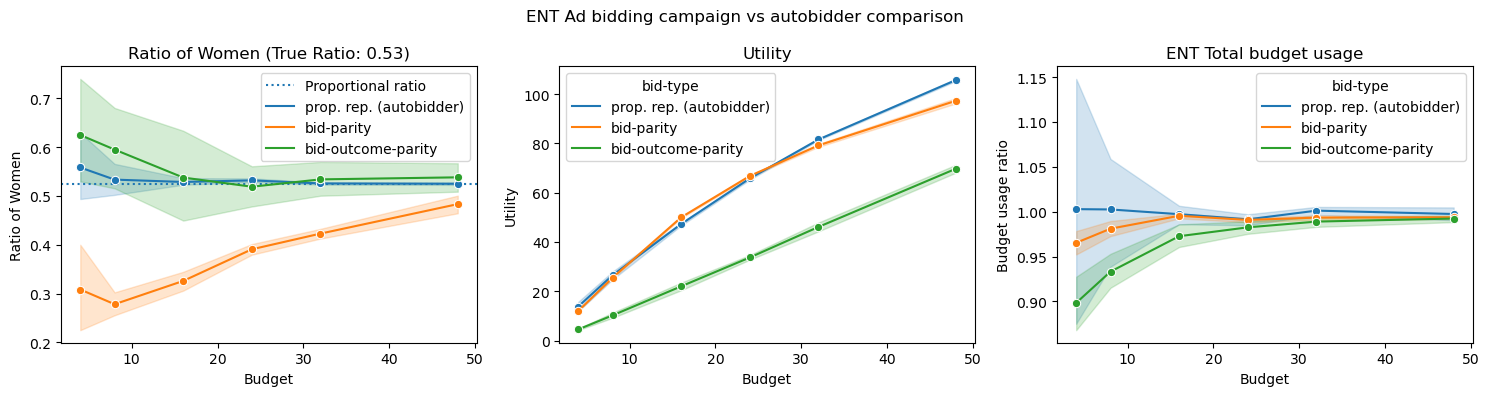

<IPython.core.display.Javascript object>

In [13]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 4))
# plot ratio
ax = axes[0]
ax.axhline(
    gamma,
    label="Proportional ratio",
    linestyle=":",
)

true_ratio = all_candidates[2] / len(sample_data[sample_data["COCCP"] == job_industry])
sns.lineplot(
    data=outcome_df,
    x="total_budget",
    y="tr_women",
    hue="bid-type",
    ax=ax,
    marker="o",
    markers=True,
)
# ax.set_ylim(0, 0.5)
ax.set_xlabel("Budget")
ax.set_ylabel("Ratio of Women")
ax.set_title(f"Ratio of Women (True Ratio: {np.round(true_ratio, 2)})")
ax.legend()
# plot total
ax = axes[1]

sns.lineplot(
    data=outcome_df,
    x="total_budget",
    y="t",
    ax=ax,
    hue="bid-type",
    marker="o",
)
ax.set_xlabel("Budget")
ax.set_ylabel(r"Utility")
ax.set_title("Utility")

# plot total
ax = axes[2]

sns.lineplot(
    data=outcome_df,
    x="total_budget",
    y="budget_usage",
    ax=ax,
    hue="bid-type",
    marker="o",
)

ax.set_xlabel("Budget")
ax.set_ylabel("Budget usage ratio")
ax.set_title(f"{job_industry} Total budget usage")
save_str = f"{job_industry} Ad bidding campaign vs autobidder comparison"
plt.suptitle(save_str)
fig.tight_layout()
plt.savefig(f"img/campvsautobidder{job_industry}-{states[0]}.pdf")